# Bitcoin - Buy or Sell?
Objective: Forecast bitcoin closing prices to inform potential buyers and sellers of price changes.

## Load and Clean Data

In [1]:
import numpy as np
import pandas as pd
import scipy
import datetime as datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import pacf, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse, aic
import fbprophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import math
import pmdarima as pm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.tsa.holtwinters import ExponentialSmoothing

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
# Load data to forecast (training set)
bitcoin = pd.read_csv('yahoo_BTC-USD_d_train.csv')

# Load external variables/features
cpi = pd.read_csv('fed_bls_cpi_us.csv')
dow = pd.read_csv('yahoo_DJI_d.csv')
sp = pd.read_csv('yahoo_SP500_d.csv')
usd = pd.read_csv('yahoo_USD_d.csv')
vix = pd.read_csv('yahoo_VIX_d.csv')
interest = pd.read_csv('fed_interest_rates_us.csv')
trend = pd.read_csv('trend_bitcoin.csv')
unemploy = pd.read_csv('fed_bls_unemployment_us.csv')

# Load actual data to evaluate forecast (test set)
actual = pd.read_csv('yahoo_BTC-USD_d_test.csv')

In [3]:
# Add time series 'date' column to actual data frame
actual['date'] = pd.to_datetime(actual['Date'])

# Drop unwanted columns
actual.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Rename column
actual.rename(columns={'Close': 'actual_close'}, inplace=True)

# Use forward fill to fill in missing values
actual.fillna(method='ffill', inplace=True)

# Check data frame
actual

,actual_close,date
0,7200.174316,2020-01-01
1,6985.470215,2020-01-02
2,7344.884277,2020-01-03
3,7410.656738,2020-01-04
4,7411.317383,2020-01-05
...,...,...
98,7334.098633,2020-04-08
99,7302.089355,2020-04-09
100,7302.089355,2020-04-10
101,7302.089355,2020-04-11


In [4]:
# Add time series 'date' column to unemployment data frame
unemploy['date'] = pd.date_range(start='2014-01-01', end='2020-03-01', normalize=True, freq='MS')

# Drop unwanted column
unemploy.drop(['Series ID', 'Year', 'Period'], axis=1, inplace=True)

# Rename column
unemploy.rename(columns={'Value': 'unemploy'}, inplace=True)

# Check data frame
unemploy.head()

,unemploy,date
0,6.6,2014-01-01
1,6.7,2014-02-01
2,6.7,2014-03-01
3,6.2,2014-04-01
4,6.3,2014-05-01


In [5]:
# Add time series 'date' column to trend data frame
trend['date'] = pd.to_datetime(trend['Month'])

# Drop unwanted column
trend.drop('Month', axis=1, inplace=True)

# Rename column
trend.rename(columns={'bitcoin: (Worldwide)': 'trend'}, inplace=True)

# Check data frame
trend.head()

,trend,date
0,3,2014-12-01
1,3,2015-01-01
2,3,2015-02-01
3,3,2015-03-01
4,2,2015-04-01


In [6]:
# Add time series 'date' column to cpi data frame
cpi['date'] = pd.to_datetime(cpi['Month'])

# Drop unwanted column
cpi.drop('Month', axis=1, inplace=True)

# Rename column
cpi.rename(columns={'CPI': 'cpi'}, inplace=True)

# Check data frame
cpi.head()

,cpi,date
0,234.812,2014-12-01
1,233.707,2015-01-01
2,234.722,2015-02-01
3,236.119,2015-03-01
4,236.599,2015-04-01


In [7]:
# Add time series 'date' column to interest data frame
interest['date'] = pd.to_datetime(interest['Series Description'])

# Drop unwanted columns
col_to_drop = interest.columns.to_list()
col_to_drop.remove('Market yield on U.S. Treasury securities at 1-month   constant maturity, quoted on investment basis')
col_to_drop.remove('date')

interest.drop(col_to_drop, axis=1, inplace=True)

# Rename column to interest
interest.rename(columns={'Market yield on U.S. Treasury securities at 1-month   constant maturity, quoted on investment basis': 'interest'}, inplace=True)

# Make interest data numeric
interest['interest'] = pd.to_numeric(interest['interest'], errors='coerce')

# Check data frame
interest.head()

,interest,date
0,0.01,2014-12-01
1,0.04,2014-12-02
2,0.03,2014-12-03
3,0.03,2014-12-04
4,0.02,2014-12-05


In [8]:
# Make list of data frames that need to be cleaned
# and list of columns to drop
df_to_clean = [bitcoin, dow, sp, usd, vix]
col_to_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

# Rename 'Date' column to 'date', clarify 'Close' column,
# change 'date' column from object to datetime, and drop
# unwanted columns
for i, df in enumerate(df_to_clean):
    name_list = ['bitcoin', 'dow', 'sp', 'usd', 'vix']
    df.rename(columns={'Date': 'date', 'Close': '{}_close'.format(name_list[i])}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.drop(col_to_drop, axis=1, inplace=True)

In [9]:
# Check data frames
bitcoin.head()

,date,bitcoin_close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [10]:
dow.head()

,date,dow_close
0,2014-12-01,17776.800781
1,2014-12-02,17879.550781
2,2014-12-03,17912.619141
3,2014-12-04,17900.099609
4,2014-12-05,17958.789063


In [11]:
sp.head()

,date,sp_close
0,2014-12-01,2053.439941
1,2014-12-02,2066.550049
2,2014-12-03,2074.330078
3,2014-12-04,2071.919922
4,2014-12-05,2075.370117


In [12]:
usd.head()

,date,usd_close
0,2014-12-01,87.949997
1,2014-12-02,88.650002
2,2014-12-03,88.959999
3,2014-12-04,88.699997
4,2014-12-05,89.330002


In [13]:
vix.head()

,date,vix_close
0,2014-12-01,14.16
1,2014-12-02,12.85
2,2014-12-03,12.50
3,2014-12-04,12.38
4,2014-12-05,11.89


In [14]:
# Make final data frame to store all variables of interest
final = bitcoin[['date', 'bitcoin_close']].copy()
final.head()

,date,bitcoin_close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [15]:
# Merge all data frames into one
df_to_merge = [dow, sp, usd, vix]
for i, df in enumerate(df_to_merge):
    name_list = ['dow', 'sp', 'usd', 'vix']
    final = final.merge(df[['date', '{}_close'.format(name_list[i])]], how='inner', on='date')
    
final = final.merge(interest[['date','interest']], how='inner', left_on='date', right_on='date')
final = final.merge(trend[['date','trend']], how='left', left_on='date', right_on='date')
final = final.merge(cpi[['date','cpi']], how='left', left_on='date', right_on='date')
final = final.merge(unemploy[['date','unemploy']], how='left', left_on='date', right_on='date')

# Check data types
final.dtypes

date             datetime64[ns]
bitcoin_close           float64
dow_close               float64
sp_close                float64
usd_close               float64
vix_close               float64
interest                float64
trend                   float64
cpi                     float64
unemploy                float64
dtype: object

In [16]:
# Use forward fill to fill in missing trend, unemploy, and cpi values
final['trend'].ffill(inplace=True)
final['unemploy'].ffill(inplace=True)
final['cpi'].ffill(inplace=True)

In [17]:
# Check final data frame
final

,date,bitcoin_close,dow_close,sp_close,usd_close,vix_close,interest,trend,cpi,unemploy
0,2014-12-01,379.244995,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,234.812,5.6
1,2014-12-02,381.315002,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,234.812,5.6
2,2014-12-03,375.010010,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,234.812,5.6
3,2014-12-04,369.604004,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,234.812,5.6
4,2014-12-05,376.854004,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,234.812,5.6
...,...,...,...,...,...,...,...,...,...,...
1273,2019-12-24,7322.532227,28515.449219,3223.379883,NaN,12.67,1.55,11.0,257.208,3.5
1274,2019-12-26,7238.966797,28621.390625,3239.909912,97.589996,12.65,1.59,11.0,257.208,3.5
1275,2019-12-27,7290.088379,28645.259766,3240.020020,96.919998,13.43,1.56,11.0,257.208,3.5
1276,2019-12-30,7292.995117,28462.140625,3221.290039,96.739998,14.82,1.51,11.0,257.208,3.5


In [18]:
# Check for any remaining missing values
final.isnull().sum()

date             0
bitcoin_close    0
dow_close        0
sp_close         0
usd_close        9
vix_close        0
interest         7
trend            0
cpi              0
unemploy         0
dtype: int64

In [19]:
# Use forward fill to fill in missing values
final.fillna(method='ffill', inplace=True)

# Reset index
final.reset_index(inplace=True, drop=True)

# Check final data frame
final

,date,bitcoin_close,dow_close,sp_close,usd_close,vix_close,interest,trend,cpi,unemploy
0,2014-12-01,379.244995,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,234.812,5.6
1,2014-12-02,381.315002,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,234.812,5.6
2,2014-12-03,375.010010,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,234.812,5.6
3,2014-12-04,369.604004,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,234.812,5.6
4,2014-12-05,376.854004,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,234.812,5.6
...,...,...,...,...,...,...,...,...,...,...
1273,2019-12-24,7322.532227,28515.449219,3223.379883,97.680000,12.67,1.55,11.0,257.208,3.5
1274,2019-12-26,7238.966797,28621.390625,3239.909912,97.589996,12.65,1.59,11.0,257.208,3.5
1275,2019-12-27,7290.088379,28645.259766,3240.020020,96.919998,13.43,1.56,11.0,257.208,3.5
1276,2019-12-30,7292.995117,28462.140625,3221.290039,96.739998,14.82,1.51,11.0,257.208,3.5


In [20]:
# Recheck for missing values
final.isnull().sum()

date             0
bitcoin_close    0
dow_close        0
sp_close         0
usd_close        0
vix_close        0
interest         0
trend            0
cpi              0
unemploy         0
dtype: int64

### Summary

So far, I have loaded and merged historical date (December 2014 to December 2019) for bitcoin closing prices (finance.yahoo.com), as well as Consumer Price Index (bls.gov), Dow Jones Industrial Average closing prices (finance.yahoo.com), S&P 500 Index closing prices (finance.yahoo.com), US dollar index (finance.yaho.com), Volatility Index closing prices (finance.yahoo.com), US interest rates (bls.gov), bitcoin search trends (trends.google.com), and US unemployment rates (bls.gov). I will use the time series data in this final data frame to forecast bitcoin closing prices.

## Explore Data

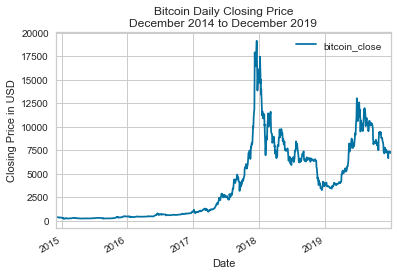

In [21]:
# Plot bitcoin time series
final.plot(x='date', y='bitcoin_close')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

Since bitcoin (and cryptocurrency, in general) didn't really become popular until mid-2017, the historical data is a bit limited. The time series above suggests that there may be some seasonality, perhaps yearly, but it is difficult to tell with only about 1.5 cycles.

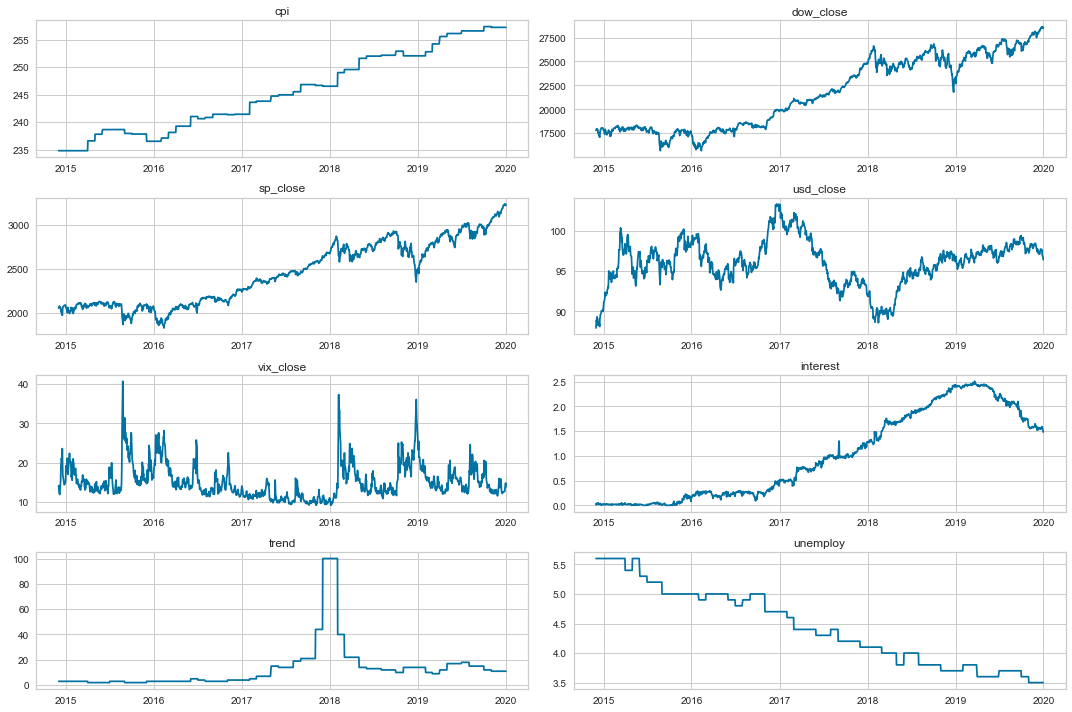

In [22]:
# Plot 8 external variables
column_list = ['cpi', 'dow_close', 'sp_close', 'usd_close',
               'vix_close', 'interest', 'trend', 'unemploy']

plt.figure(figsize=(15, 10))

for i, col in enumerate(column_list):
    plt.subplot(4, 2, i + 1)
    plt.plot(final['date'], final[col])
    plt.title(col)

# Show plots
plt.tight_layout()
plt.show()

Although none of these external time series exactly match the bitcoin time series, we do see some potential relationships. For example, the USD index drops significantly in 2018, almost mirroring the rapid growth of bitcoin at that time. One potential explanation is that people were losing faith in the value of the US dollar, so they began exploring other investment options, including cryptocurrency. Additionally, we see a huge spike in bitcoin search trends at the beginning of 2018, again corresponding with a rise in bitcoin prices. Although causation cannot be drawn from these grpahical relationships, it makes sense that rising bitcoin prices would fuel public interest and public interest would raise bitcoin prices (increased demand). Finally, we see several interesting relationships between these external data sets, perhaps most notably the striking similarity between Dow and S&P 500 and the anti-correlation between unemployment and CPI. I will explore these relationships quantitatively, rather than qualitatively, in the next two cells.

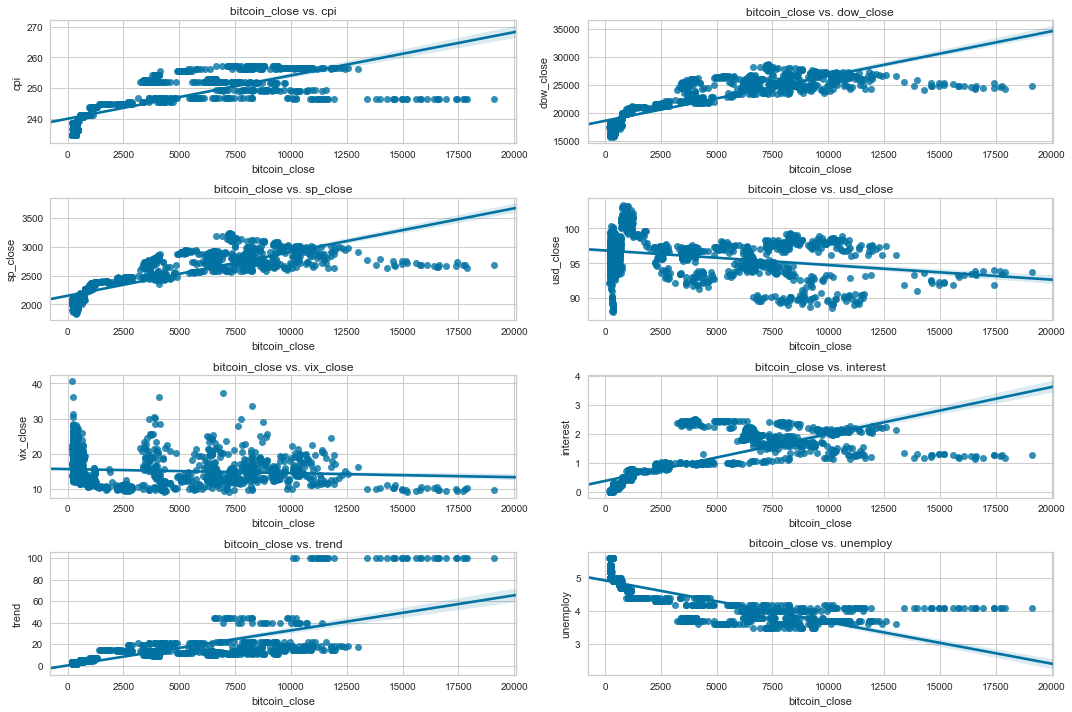

In [23]:
# Plot bitcoin vs. 8 external variables to evaluate
# bivariate relationships
column_list = ['cpi', 'dow_close', 'sp_close', 'usd_close',
               'vix_close', 'interest', 'trend', 'unemploy']

plt.figure(figsize=(15, 10))

for i, col in enumerate(column_list):
    plt.subplot(4, 2, i + 1)
    sns.regplot(x=final['bitcoin_close'], y=final[col])
    plt.title('bitcoin_close vs. ' + col)
    plt.xlabel('bitcoin_close')
    plt.ylabel(col)

# Show plots
plt.tight_layout()
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


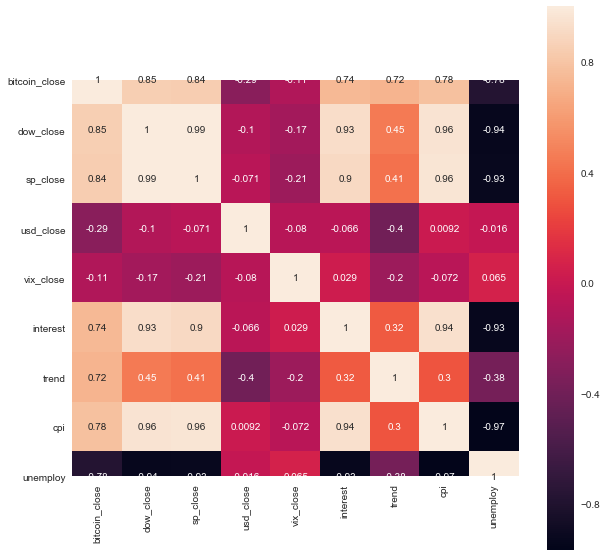

In [24]:
# Plot correlation matrix as heat meap
corr_mat = final.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=True, square=True)

plt.show()

As demonstrated qualitatively in the univariate plots and more quantitatively in the bivariate plots and correlation matrix heatmap above, the closing bitcoin price is most closely associated with google search trend (0.72), interest rate (0.74), CPI (0.78), S&P500 closing price (0.84), and Dow closing price (0.85). Interest rate, S&P50 closing price, Dow closing price, and CPI are also highly correlated with each other. These results suggest that supervised learning models will likely work best with some combination of trend and one of the other highly correlated variables. However, adding all of the highly correlated variables will not add very much 'new' information to the model.

## Build and Evaluate Models

### Facebook Prophet Model
First, I will forecast the closing price of bitcoin using the Facebook Prophet (FBP) model, which is an additive model best equipped to handle trends, seasonalities, and holidays in time series data. Generally speaking, it works via a process of curve-fitting (focus change points), which is in contrast to other time series models, such as ARIMA, that rely on temporal dependencies within the data.

In [25]:
# Create new data frame for bitcoin prices
gm = final[['date', 'bitcoin_close']].copy()
gm.rename(columns={'date': 'ds', 'bitcoin_close': 'y'}, inplace=True)

# Check end of data frame
gm.tail()

,ds,y
1273,2019-12-24,7322.532227
1274,2019-12-26,7238.966797
1275,2019-12-27,7290.088379
1276,2019-12-30,7292.995117
1277,2019-12-31,7193.599121


In [26]:
# Instantiate new prophet object and fit model
gm_prophet = fbprophet.Prophet(growth='linear',
                               seasonality_mode='additive',
                               changepoint_prior_scale=1,
                               daily_seasonality=False,
                               weekly_seasonality=False,
                               yearly_seasonality=False
                               ).add_seasonality(
                                    name='custom',
                                    period=450,
                                    fourier_order=10)

gm_prophet.fit(gm)

# Use model to forecast daily bitcoin prices 90
# days into the future
gm_forecast = gm_prophet.make_future_dataframe(periods=90, freq='D')
gm_forecast = gm_prophet.predict(gm_forecast)

The bitcoin time series data does not have any obvious daily, weekly, or yearly seasonality; however, as mentioned previously, the price seem to rise and peak about every 1.5 years with perhaps a slight increasing trend overall. Thus, I turned off the default seasonalities and added a custom seasonality to capture this unique pattern. The caveat here is that with limited data and only 1.5 cycles, it is difficult to know if this 1.5 year seasonality is real or just an artifact. I also manually adjusted the changepoint_prior_scale to tune the model. If the model was overfittting (too much flexibility), I decreased the changepoint prior scale, and if it was underfitting (too little flexibility), I increased the changepoint prior scale. I settled on a value of 1 (default is 0.05).

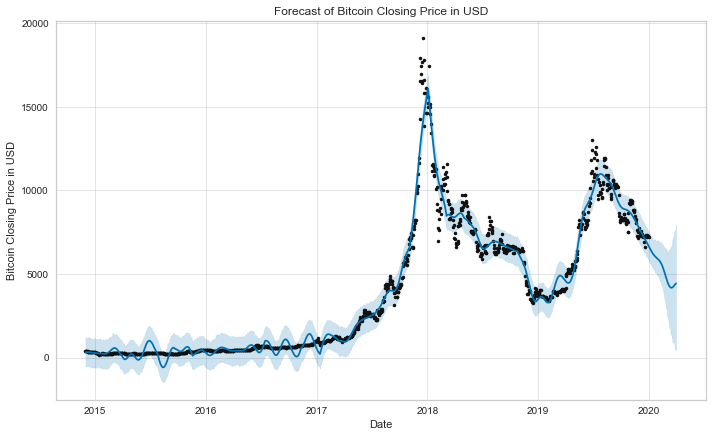

In [27]:
# Plot the actual prices along with the forecast
gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.show()

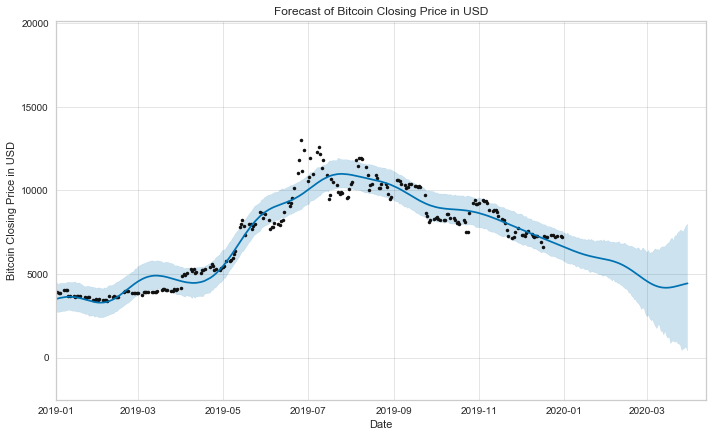

In [28]:
# Zoom in on the years 2019 and 2020
gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
plt.xlim([datetime.date(2019, 1, 1)], [datetime.date(2020, 4, 12)])
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.show()

As demonstrated in the two plots above, the FBP model forecasts the general trends in the training data pretty well. However, in the second plot, we can see that the model fails to capture all of the noise. This is in part because we do not want to overfit the model, but it also suggests that there is some information that is not being captured by the model that could potentially be meaningful in predicting bitcoin prices. Here, we also see the 95% confidence interval in light blue, which is a range of values that we can be 95% certain captures the actual bitcoin price.

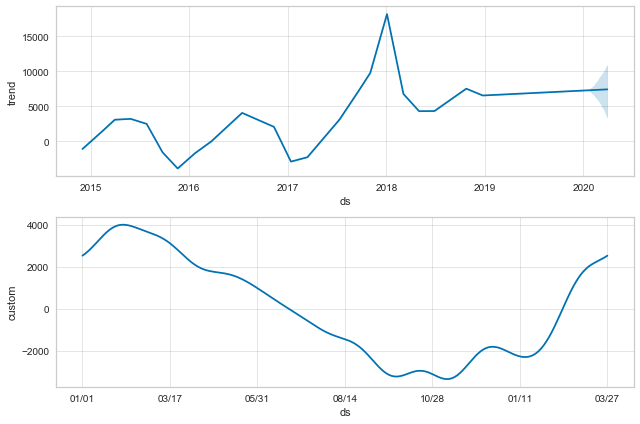

In [29]:
# Look at the trend and seasonality components of
# the bitcoin forecast
gm_prophet.plot_components(gm_forecast);

These component plots show the trend and custom seasonality components that make up the additive FBP model.

In [30]:
# Use built-in cross validation to assess prediction
# performance on a horizon of three months
fbp_cv = cross_validation(gm_prophet, initial='730 days', period='30 days', horizon='60 days')

fbp_cv.head()

INFO:fbprophet:Making 36 forecasts with cutoffs between 2016-12-16 00:00:00 and 2019-11-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-12-19,788.500895,766.669225,812.624743,792.713989,2016-12-16
1,2016-12-20,789.873986,768.867564,812.198678,800.875977,2016-12-16
2,2016-12-21,791.346371,767.489341,813.926341,834.281006,2016-12-16
3,2016-12-22,792.948515,769.766038,815.143565,864.539978,2016-12-16
4,2016-12-23,794.710858,770.940661,817.650998,921.984009,2016-12-16


Note: Initial refers to the size of the initial training period, horizon refers to the forecast horizon, and period refers to the spacing between cutoff dates.

Here, I assess prediction performance on the training data set over a horizon of 60 days, starting with 730 days of training data in the first cutoff and then making predictions every 30 days. This corresponds to a total of 36 forecasts, which can also be thought of as cross validations.

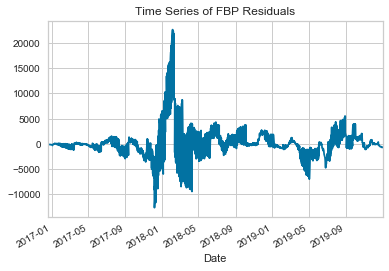

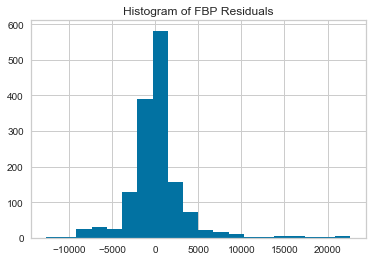

In [31]:
# Calculate residuals
residuals = pd.DataFrame(fbp_cv['yhat'] - fbp_cv['y'])
residuals['date'] = fbp_cv['ds']

# Plot time series and histogram of residuals
residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of FBP Residuals')

residuals.hist(bins=20)
plt.title('Histogram of FBP Residuals')

plt.show()

In [32]:
jb_results = jarque_bera(residuals[0])

print('Test Statistic: ', jb_results[0])
print('P-value: ', jb_results[1])
print('Skew: ', jb_results[2])
print('Kurtosis: ', jb_results[3])

Test Statistic:  9218.113566659607
P-value:  0.0
Skew:  1.8637887275066067
Kurtosis:  14.613974489316087


The time series plot of the residuals shows that the largest residuals occur during the peak in 2018, which makes sense because the model does not capture the potential outliers in the 15,000+ dollar range. We see a similar effect with the peak in mid- to late-2019. The histogram of the residuals, along with the results from the Jarque Bera normality test, also show that the residuals are not normally distributed, with a p-value less than 0.05, a slight positive skew (1.9 vs. 0 for a normal distribution), which again is caused by those outliers in the 15,000+ dollar range), and a high kurtosis (14.6 vs. 3 for a normal distribution).

In [33]:
# Use built-in performance metrics to evaluate model
fbp_p = performance_metrics(fbp_cv)
fbp_p

,horizon,mse,rmse,mae,mape,coverage
0,6 days,9.447973e+05,972.006851,677.278973,0.110485,0.443412
1,7 days,1.181061e+06,1086.766332,718.329449,0.115467,0.424324
2,8 days,1.373043e+06,1171.769086,760.178809,0.122845,0.408784
3,9 days,1.572766e+06,1254.099675,808.142754,0.129109,0.386175
4,10 days,1.639450e+06,1280.410089,832.904333,0.132416,0.365676
5,11 days,1.980498e+06,1407.301635,890.944308,0.137410,0.337297
6,12 days,2.246058e+06,1498.685372,944.191418,0.145851,0.324064
7,13 days,2.508671e+06,1583.878499,1001.730422,0.154095,0.310270
8,14 days,2.867799e+06,1693.457589,1080.373287,0.162408,0.283784
9,15 days,3.147972e+06,1774.252416,1157.408959,0.172239,0.263514


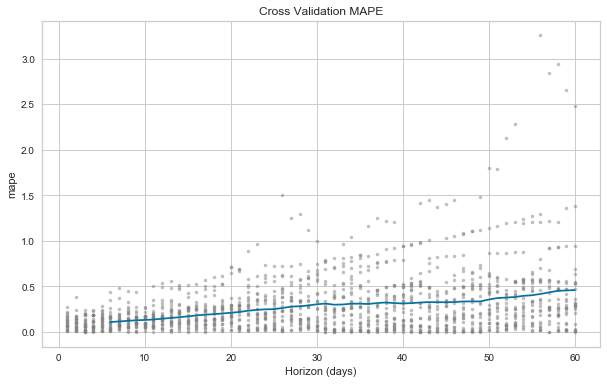

In [34]:
# Plot MAPE metric from cross validation
mape_fig = plot_cross_validation_metric(fbp_cv, metric='mape')
plt.title('Cross Validation MAPE')
plt.show()

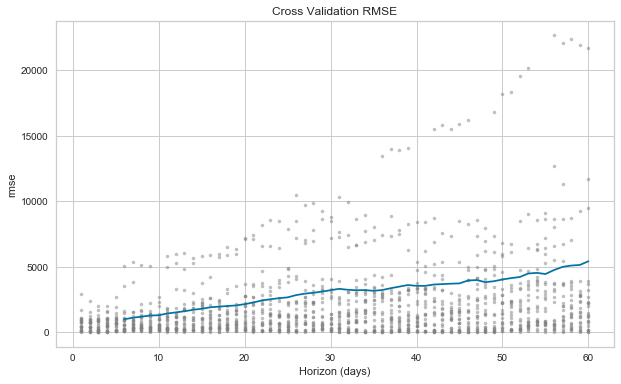

In [35]:
# Plot RMSE metric from cross validation
rmse_fig = plot_cross_validation_metric(fbp_cv, metric='rmse')
plt.title('Cross Validation RMSE')
plt.show()

By manually tuning the FBP parameters (growth, seasonality method, changepoint prior scale, and seasonality), I was able to reduce the 6-day RMSE and MAPE from 2590.143614 and 26.9316% to 972 and 11%, respectively. However, in the plots above, we can see that the average RMSE and MAPE increase as the forecast window gets larger, suggesting that the model can reasonably predict bitcoin prices 1 to 6 days into the future, but does a poor job of predicting prices any farther than that (for example, at one or two months into the future).

In [36]:
# Store forecasted prices in a data frame
fbp = gm_forecast[['ds', 'yhat']][(gm_forecast['ds'] >= datetime.date(2020, 1, 1)) & (gm_forecast['ds'] < datetime.date(2020, 4, 13))]
fbp.rename(columns={'ds': 'date', 'yhat': 'fbp_forecast'}, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [37]:
# Add forecasted prices to actual data frame for comparison
actual = actual.merge(fbp, how='inner', left_on='date', right_on='date')
actual

,actual_close,date,fbp_forecast
0,7200.174316,2020-01-01,6623.369216
1,6985.470215,2020-01-02,6588.544523
2,7344.884277,2020-01-03,6553.886240
3,7410.656738,2020-01-04,6519.470163
4,7411.317383,2020-01-05,6485.377436
...,...,...,...
85,6716.440430,2020-03-26,4354.392369
86,6469.798340,2020-03-27,4376.606467
87,6242.193848,2020-03-28,4397.854482
88,5922.042969,2020-03-29,4417.721627


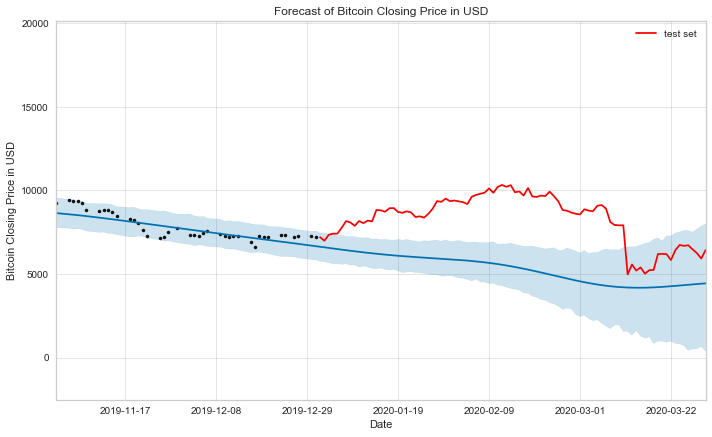

In [38]:
# Zoom in on the years 2019 and 2020
gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
plt.plot(actual['date'], actual['actual_close'], c='red', label='test set')
plt.xlim([datetime.date(2019, 11, 1)], [datetime.date(2020, 3, 30)])
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.legend()
plt.show()

In [39]:
# Use RMSE and MAE to evaluate 7-day performance of prophet model
# on the test/actual set
print('Facebook Prophet 7-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['fbp_forecast'][0:7]) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['fbp_forecast'][0:7]))

Facebook Prophet 7-Day Performance
RMSE: 1038.48
MAE: 949.22


In [40]:
# Use RMSE and MAE to evaluate 90-day performance of prophet model
# on the test/actual set
print('Facebook Prophet 90-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'], actual['fbp_forecast']) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['fbp_forecast']))

Facebook Prophet 90-Day Performance
RMSE: 3271.15
MAE: 2999.27


As we can see in the plot above, the FBP model is able to forecast the immediate future (1 to 6 days), much as we saw with the training set cross validation results. This performance trend is also evident in the 7-day and 90-day RMSE and MAE measures for the test set, which show much lower levels of error at 7-days compared to 90 days. Interestingly, the model appears to forecast 90+ days somewhat accurately (within the light blue confidence interval). This may suggest that the model can capture general trends, but fails to capture more local, rapid changes.

#### Summary

The strength of the FBP model lies in its ability to forecast time series data with trends, seasonality, and holidays. Unfortunately, the bitcoin time series data does not have strong components of any of these, perhaps explaining why the model performed relatively poorly. However, it may still have some utility in forecasting bitcoin prices up to a week into the future.

### VAR Model
Next, I will use a vector autoregression (VAR) model to forecast bitcoin prices. VAR is a multivariate forecasting algorithm used for time series that influence each other (bi-directional), unlike ARIMA models, which are univariate and uni-directional. Thus, to build this VAR model, I will use some of the external time series data sets explored in the first section. 

The code for this model is adapted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/.

In [41]:
# Change index to values in date column
final_var = final.set_index('date')
final_var.head()

,bitcoin_close,dow_close,sp_close,usd_close,vix_close,interest,trend,cpi,unemploy
date,,,,,,,,,
2014-12-01,379.244995,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,234.812,5.6
2014-12-02,381.315002,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,234.812,5.6
2014-12-03,375.010010,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,234.812,5.6
2014-12-04,369.604004,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,234.812,5.6
2014-12-05,376.854004,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,234.812,5.6


The trend, cpi, and unemployment data is monthly rather than daily, which is difficult to use when differencing (all or mostly 0s), so I am going to drop these variables.

In [42]:
# Drop trend, cpi, and unemploy columns
final_var.drop(columns=['trend', 'cpi', 'unemploy'], inplace=True)

# Check resulting data frame
final_var

,bitcoin_close,dow_close,sp_close,usd_close,vix_close,interest
date,,,,,,
2014-12-01,379.244995,17776.800781,2053.439941,87.949997,14.16,0.01
2014-12-02,381.315002,17879.550781,2066.550049,88.650002,12.85,0.04
2014-12-03,375.010010,17912.619141,2074.330078,88.959999,12.50,0.03
2014-12-04,369.604004,17900.099609,2071.919922,88.699997,12.38,0.03
2014-12-05,376.854004,17958.789063,2075.370117,89.330002,11.89,0.02
...,...,...,...,...,...,...
2019-12-24,7322.532227,28515.449219,3223.379883,97.680000,12.67,1.55
2019-12-26,7238.966797,28621.390625,3239.909912,97.589996,12.65,1.59
2019-12-27,7290.088379,28645.259766,3240.020020,96.919998,13.43,1.56


In [43]:
# Use Granger's causality test to determine if 
# the time series influence each other
maxlag = 12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the p-values. P-values less than the significance level (0.05) imply that 
    the null hypothesis that past values of X do not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(final_var, variables=final_var.columns)

,bitcoin_close_x,dow_close_x,sp_close_x,usd_close_x,vix_close_x,interest_x
bitcoin_close_y,1.0000,0.0833,0.1072,0.8879,0.5793,0.1387
dow_close_y,0.0304,1.0000,0.1667,0.1429,0.0660,0.0582
sp_close_y,0.0345,0.1090,1.0000,0.2738,0.0354,0.0944
usd_close_y,0.0771,0.3394,0.3501,1.0000,0.1541,0.1076
vix_close_y,0.0672,0.3284,0.0982,0.2786,1.0000,0.1288
interest_y,0.3583,0.1625,0.2323,0.1361,0.0374,1.0000


Note: The rows are the response variables (Y) and the columns are the predictive variables (X).

Dow is the only one with a p-value less than or close to 0.05 for bitcoin_close, suggesting that this time series may explain or cause bitcoin closing prices. Accordingly, I will drop the other variables from the final_var data set.

In [44]:
# Change index to values in date column
final_var.drop(columns=['sp_close', 'interest', 'usd_close', 'vix_close'], inplace=True)
final_var.head()

,bitcoin_close,dow_close
date,,
2014-12-01,379.244995,17776.800781
2014-12-02,381.315002,17879.550781
2014-12-03,375.010010,17912.619141
2014-12-04,369.604004,17900.099609
2014-12-05,376.854004,17958.789063


In [45]:
# Check for cointegration between the time series
# Cointegration refers to the presence of a statistically
# significant relationship between two or more time series
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, -1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(final_var)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
bitcoin_close ::  7.26      > 12.3212   =>   False
dow_close ::  2.81      > 4.1296    =>   False


Johanson's cointegration test is not significant for bitcoin or dow (test statistic less than 95% confidence interval), implying that there is not a statistically significant relationship between these variables. This is not a surprise, since the Granger causality test showed no significant causation between the two variables. However, for the sake of creating the VAR model, I will continue.

In [46]:
# Use the Augmented Dickey-Fuller Test (ADF Test)
# to check if time series are stationary
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [47]:
# Run ADF Test on each column
for name, column in final_var.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "bitcoin_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6834
 No. Lags Chosen       = 18
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.4397. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "dow_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2431
 No. Lags Chosen       = 0
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.9332. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




Neither time series is stationary, so I will take the first difference.

In [48]:
# Take first difference
final_var_diff_1 = final_var.diff().dropna()

# Rerun ADF Test on each column
for name, column in final_var_diff_1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "bitcoin_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.38
 No. Lags Chosen       = 17
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dow_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.4557
 No. Lags Chosen       = 1
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




After taking the first difference, both time series are stationary.

In [49]:
# Determine the order (P) of the VAR model using AIC
model = VAR(final_var_diff_1)

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  22.04670267515635
BIC :  22.070925961036778
FPE :  3756309109.704169
HQIC:  22.055799729316067 

Lag Order = 2
AIC :  22.05220924522485
BIC :  22.092606903715772
FPE :  3777050781.956691
HQIC:  22.067381173975452 

Lag Order = 3
AIC :  22.05245599436098
BIC :  22.109048487065728
FPE :  3777983412.7592196
HQIC:  22.0737109553572 

Lag Order = 4
AIC :  22.054891652455584
BIC :  22.127699483385697
FPE :  3787197450.910152
HQIC:  22.08223782072343 

Lag Order = 5
AIC :  22.057747004150198
BIC :  22.146790719846585
FPE :  3798028170.427158
HQIC:  22.091192572137377 

Lag Order = 6
AIC :  22.061813211527756
BIC :  22.167113401182302
FPE :  3813505334.125581
HQIC:  22.101366389154293 

Lag Order = 7
AIC :  22.045971408775028
BIC :  22.16754870435265
FPE :  3753571432.9240627
HQIC:  22.091640423484073 

Lag Order = 8
AIC :  22.03710965362414
BIC :  22.17498472998528
FPE :  3720458906.2016163
HQIC:  22.08890275043296 

Lag Order = 9
AIC :  22.04139595033082
BIC :  22.195589

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag 1 produces the smallest AIC (20.05) before the AIC values increase, so I will continue with a 1st order VAR model.

In [50]:
# Build 1st order VAR model
model_fit = model.fit(1)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 19, Apr, 2020
Time:                     10:04:43
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    22.0709
Nobs:                     1276.00    HQIC:                   22.0558
Log likelihood:          -17680.9    FPE:                3.75631e+09
AIC:                      22.0467    Det(Omega_mle):     3.73871e+09
--------------------------------------------------------------------
Results for equation bitcoin_close
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    5.688815         9.230201            0.616           0.538
L1.bitcoin_close        -0.026138         0.028021           -0.933           0.351
L1.dow_close            -0.024888       

As we can see in the prob column above, none of the coefficients have p-values less than 0.05, indicating that these coefficients are not playing a significant role in the model.

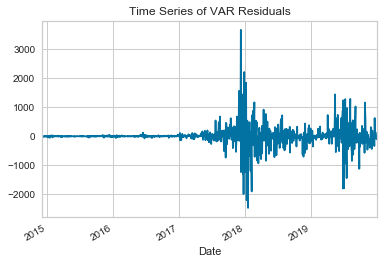

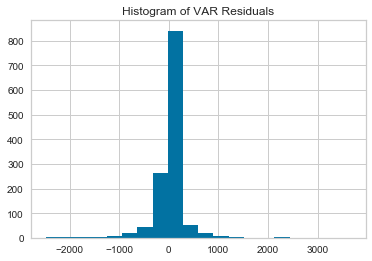

In [51]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid['bitcoin_close'])

residuals.plot(legend=False)
plt.xlabel('Date')
plt.title('Time Series of VAR Residuals')

residuals.hist(bins=20)
plt.title('Histogram of VAR Residuals')

plt.show()

In [52]:
results = jarque_bera(residuals['bitcoin_close'])

print('Test Statistic: ', results[0])
print('P-value: ', results[1])
print('Skew: ', results[2])
print('Kurtosis: ', results[3])

Test Statistic:  36551.03436244144
P-value:  0.0
Skew:  0.667260323979181
Kurtosis:  29.185861161705894


In [53]:
residuals

,bitcoin_close
date,
2014-12-03,-9.382489
2014-12-04,-10.436624
2014-12-05,1.108301
2014-12-08,-18.983676
2014-12-09,-18.415227
...,...
2019-12-24,-32.808881
2019-12-26,-91.017258
2019-12-27,45.885189


Unfortunately, we do see some pattern to the time series of the residuals, with the largest errors corresponding to the two peaks in early 2018 and late 2019. Additionally, the residuals are not normally distributed, but this is largely driven by high kurtosis rather than skewness. Compared to the FBP residuals, these residuals are much smaller, but seem to rise and fall systematically due to a lack of correction for the 1.5-year seasonality.

In [54]:
# Load VAR test sets
bit_var = pd.read_csv('yahoo_BTC-USD_d_test.csv')
dow_var = pd.read_csv('yahoo_DJI_d_test.csv')

# Clean and merge data sets
df_list_1 = [bit_var, dow_var]
name_list_1 = ['bit_var', 'dow_var']

for i, df in enumerate(df_list_1):
    df['date'] = pd.to_datetime(df['Date'])
    df.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
    df.rename(columns={'Close': 'actual_' + '{}'.format(name_list_1[i])}, inplace=True)

var_test = bit_var[['date', 'actual_bit_var']].copy()  
var_test = var_test.merge(dow_var, how='inner', on='date')

# Use forward fill to fill in missing values
var_test.fillna(method='ffill', inplace=True)

# Change index to values in date column
var_test = var_test.set_index('date')

# Take first difference
var_test_diff_1 = var_test.diff().dropna()

# Check final test data frame
var_test_diff_1

,actual_bit_var,actual_dow_var
date,,
2020-01-03,359.414062,-233.91992
2020-01-06,424.334961,68.50000
2020-01-07,394.473145,-119.70117
2020-01-08,-83.829590,161.41015
2020-01-09,-200.791504,211.81055
...,...,...
2020-04-03,-60.237305,-360.91015
2020-04-06,538.394043,1627.46093
2020-04-07,-95.366699,-26.13085


In [55]:
# Get the lag order
lag_order = model_fit.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = var_test_diff_1.values[-lag_order:]
forecast_input

1


array([[-32.009278, 285.79883 ]])

In [57]:
var_test

,actual_bit_var,actual_dow_var
date,,
2020-01-02,6985.470215,28868.80078
2020-01-03,7344.884277,28634.88086
2020-01-06,7769.219238,28703.38086
2020-01-07,8163.692383,28583.67969
2020-01-08,8079.862793,28745.08984
...,...,...
2020-04-03,6733.387207,21052.52930
2020-04-06,7271.781250,22679.99023
2020-04-07,7176.414551,22653.85938


In [58]:
# Forecast (remember the output will be in scale
# of first differenced data)
nobs = 69
fc = model_fit.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=var_test.index[-nobs:], columns=var_test.columns + '_1d')
df_forecast

,actual_bit_var_1d,actual_dow_var_1d
date,,
2020-01-02,-0.587413,3.590176
2020-01-03,5.614818,8.296677
2020-01-06,5.335571,8.358574
2020-01-07,5.341329,8.351857
2020-01-08,5.341346,8.352074
...,...,...
2020-04-03,5.341340,8.352071
2020-04-06,5.341340,8.352071
2020-04-07,5.341340,8.352071


In [59]:
# Invert transformation to get real forecast
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = var_test.columns
    
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (var_test[col].iloc[-1]-var_test[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = var_test[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

var_results = invert_transformation(final_var, df_forecast, second_diff=False)        
var_results = var_results.loc[:, ['actual_bit_var_forecast']]
var_results.rename(columns={'actual_bit_var_forecast': 'var_forecast'}, inplace=True)
var_results

,var_forecast
date,
2020-01-02,7301.501942
2020-01-03,7307.116759
2020-01-06,7312.452330
2020-01-07,7317.793659
2020-01-08,7323.135005
...,...
2020-04-03,7643.615419
2020-04-06,7648.956759
2020-04-07,7654.298099


In [60]:
# Add VAR forecast to actual data frame
actual = actual.merge(var_results, how='left', on='date')

# Use forward fill to fill in missing values
# (due to stock market being closed on the
# weekends) via imputation
actual['var_forecast'].ffill(inplace=True)

# Use back fill to fill in last missing value
actual.fillna(method='backfill', inplace=True)

# Check data frame
actual

,actual_close,date,fbp_forecast,var_forecast
0,7200.174316,2020-01-01,6623.369216,7301.501942
1,6985.470215,2020-01-02,6588.544523,7301.501942
2,7344.884277,2020-01-03,6553.886240,7307.116759
3,7410.656738,2020-01-04,6519.470163,7307.116759
4,7411.317383,2020-01-05,6485.377436,7307.116759
...,...,...,...,...
85,6716.440430,2020-03-26,4354.392369,7611.567377
86,6469.798340,2020-03-27,4376.606467,7616.908718
87,6242.193848,2020-03-28,4397.854482,7616.908718
88,5922.042969,2020-03-29,4417.721627,7616.908718


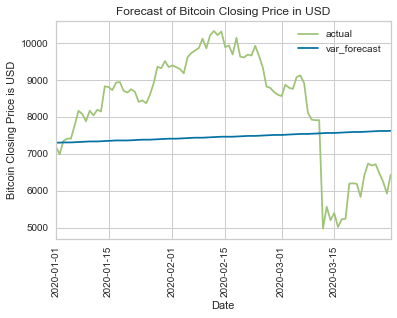

In [61]:
# Plot actual versus forecasted bitcoin prices
plt.plot(actual['date'], actual['actual_close'], c='g', label='actual')
plt.plot(actual['date'], actual['var_forecast'], c='b', label='var_forecast')
plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 3, 30)])
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.xlabel('Date')
plt.ylabel('Bitcoin Closing Price is USD')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [62]:
# Evaluate 7-day performance of model on test set
print('VAR 7-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['var_forecast'][0:7]) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['var_forecast'][0:7]))

VAR 7-Day Performance
RMSE: 388.65
MAE: 280.79


In [63]:
# Evaluate 90-day performance of model on test set
print('VAR 90-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'], actual['var_forecast']) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['var_forecast']))

VAR 90-Day Performance
RMSE: 1703.80
MAE: 1540.56


The VAR model performs much better on the test set than the FBP model did, with a 7-day RMSE and MAE of 388.65 and 280.79 and a 90-day RMSE and MAE of 1703.8 and 1540.56, respectively. For comparison, the 7-day RMSE and MAE values for the FBP model were 1038.48 and 949.22 and the 90-day values were 3271.15 and 2999.27, respectively. One potential explanation for this is that the Dow time series data set provided additional information that was not available in the FBP model; however, the differences could also be due to the inherent differences between the models (curve-fitting vs. autoregression). It is also interesting to note that the VAR forecast seems to cut right through the actual values where the FBP model took a lower path.

#### Summary

Despite the bitcoin and Dow time series failing many of the typical features of VAR models, the resulting model appears to perform slightly better on the test set than the FBP model. However, there is still a lot of room for improvement as shown by the non-normal residual plot and inability to forecast dynamic changes in bitcoin prices.

### ARIMA Model
Next, I will forecast the closing price of bitcoin using an autoregressive integrated moving average (ARIMA) model. As mentioned previously, ARIMA models are univariate, unidirectional models that predict future values of a given time series using a linear regression of past values.

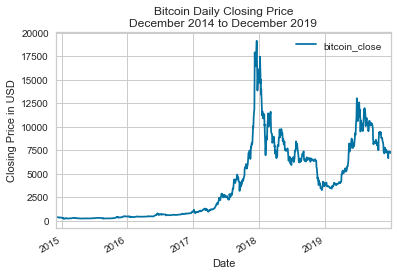

In [64]:
# Plot bitcoin time series
final.plot(x='date', y='bitcoin_close')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

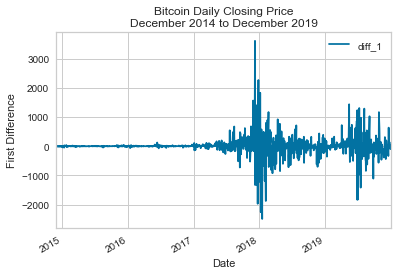

In [65]:
# Take first difference
diff = final[['date']].copy()
diff['diff_1'] = final.bitcoin_close - final.bitcoin_close.shift()

# Plot first difference to see if data set is stationary
diff.plot(x='date', y='diff_1')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('First Difference')
plt.show()

A stationary data set is one whose statistical properties, such as mean and variance, are constant over time. Although the mean and variance of the differenced time series are not quite constant over time, as depicted in the plot above, they are more constant than they were in the original data set. Moreover, we will see in the following steps, that the first differenced series provides the best model in terms of the autocorrelation function (ACF) and partial ACF (PACF) plots, as well as AIC values.

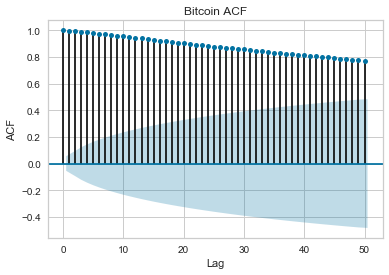

In [66]:
# Use ACF to find most optimal MA(q) model
plot_acf(final.bitcoin_close, lags=50, alpha=0.05)
plt.title('Bitcoin ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

Autocorrelations are significant for a large number of lags (50+).

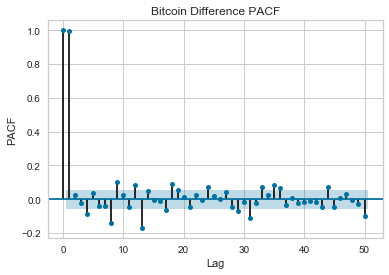

In [67]:
# Use PACF to find most optimal AR(p) model
plot_pacf(final.bitcoin_close, lags=50, alpha=0.05)
plt.title('Bitcoin Difference PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

However, the PACF plot indicates that the autocorrelations seen in the ACF plot are largely due to the propagation of the autocorrelation at lag 1.

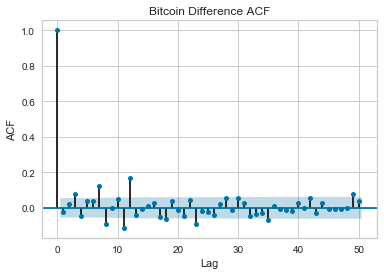

In [68]:
# Use ACF to find most optimal MA(q) model
plot_acf(diff['diff_1'][1:], lags=50, alpha=0.05)
plt.title('Bitcoin Difference ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

The ACF cuts off at lag 0, suggesting that an MA term is not needed for the differenced series.

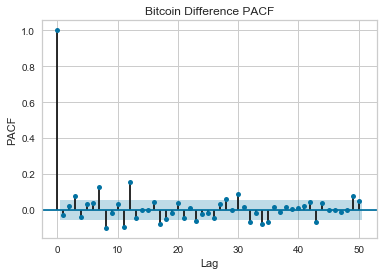

In [69]:
# Use PACF to find most optimal AR(p) model
plot_pacf(diff.diff_1[1:], lags=50, alpha=0.05)
plt.title('Bitcoin Difference PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

The PACF cuts off at lag 0, suggesting that an AR term is not needed for the differenced series. Thus, I will first build a ARIMA(0, 1, 0) model. I will then compare the performance of this model to other ARIMA models manually and automatically using auto arima.

In [70]:
# Build ARIMA(0, 1, 0) model
model = ARIMA(final.bitcoin_close, order=(0, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1277
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9213.431
Method:                           css   S.D. of innovations            328.969
Date:                Sun, 19 Apr 2020   AIC                          18430.863
Time:                        10:04:46   BIC                          18441.167
Sample:                             1   HQIC                         18434.732
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3362      9.206      0.580      0.562     -12.707      23.379


In [71]:
# Build ARIMA(1, 1, 0) model
model = ARIMA(final.bitcoin_close, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1277
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9212.986
Method:                       css-mle   S.D. of innovations            328.855
Date:                Sun, 19 Apr 2020   AIC                          18431.972
Time:                        10:04:46   BIC                          18447.429
Sample:                             1   HQIC                         18437.777
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.3362      8.966      0.595      0.552     -12.237      22.909
ar.L1.D.bitcoin_close    -0.0264      0.028     -0.944      0.345      -0.081       0.028
        

In [72]:
# Build ARIMA(0, 1, 1) model
model = ARIMA(final.bitcoin_close, order=(0, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1277
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -9213.005
Method:                       css-mle   S.D. of innovations            328.860
Date:                Sun, 19 Apr 2020   AIC                          18432.011
Time:                        10:04:46   BIC                          18447.467
Sample:                             1   HQIC                         18437.815
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.3362      8.971      0.595      0.552     -12.246      22.919
ma.L1.D.bitcoin_close    -0.0252      0.027     -0.925      0.355      -0.079       0.028
        

In [73]:
# Build ARIMA(1, 1, 1) model
model = ARIMA(final.bitcoin_close, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1277
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9212.951
Method:                       css-mle   S.D. of innovations            328.845
Date:                Sun, 19 Apr 2020   AIC                          18433.901
Time:                        10:04:46   BIC                          18454.510
Sample:                             1   HQIC                         18441.641
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.3364      8.980      0.594      0.552     -12.265      22.938
ar.L1.D.bitcoin_close    -0.1278      0.365     -0.350      0.726      -0.842       0.587
ma.L1.D.

The p-values for the AR and MR coefficients in the ARIMA(1, 1, 0), ARIMA(0, 1, 1), and ARIMA(1, 1, 1) are greater than 0.05, indicating that these coefficients do not play a significant explanatory role on the outcome and thus are not needed when d=1. The optimized ARIMA(0, 1, 0) model also produced the smallest AIC value (18430.863).

In [74]:
# Use pd.auto_arima to optimize p and q based on AIC
stepwise_fit = pm.auto_arima(final.bitcoin_close,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18431.600, BIC=18452.209, Time=0.378 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=18430.863, BIC=18441.167, Time=0.027 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=18431.973, BIC=18447.429, Time=0.052 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18432.017, BIC=18447.474, Time=0.088 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=18429.199, BIC=18434.351, Time=0.017 seconds
Total fit time: 0.567 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1278
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9213.600
Date:                Sun, 19 Apr 2020   AIC                          18429.199
Time:                        10:04:47   BIC                          18434.351
Sample:                             0   HQIC                         18431.134
                               - 1278                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.082e+05   1146.923     94.309      0.000    1.06e+05     1.1e+05
===================================================================================
Ljung-Box (Q):                      159.16   Jarque-Bera (JB):             35467.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             498.76   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

pm.auto_arima also confirmed that ARIMA(0, 1, 0) is the best model based on smallest AIC value. However, we can see in the report above that the p-value for the Jarque-Bera normality test in less than 0.05, indicating that the residuals of this model are not normally distributed. This is supported by the extremely high kurtosis (residual plots are below).

In [75]:
# Use ARIMA(0, 1, 0) model to forecast bitcoin prices
# Instantiate model
model = ARIMA(final.bitcoin_close, order=(0, 1, 0))

# Fit model
model_fit = model.fit()

# Use model to forecast and store in data frame
actual['arima_forecast'] = model_fit.forecast(steps=90)[0]
actual

,actual_close,date,fbp_forecast,var_forecast,arima_forecast
0,7200.174316,2020-01-01,6623.369216,7301.501942,7198.935342
1,6985.470215,2020-01-02,6588.544523,7301.501942,7204.271563
2,7344.884277,2020-01-03,6553.886240,7307.116759,7209.607784
3,7410.656738,2020-01-04,6519.470163,7307.116759,7214.944005
4,7411.317383,2020-01-05,6485.377436,7307.116759,7220.280226
...,...,...,...,...,...
85,6716.440430,2020-03-26,4354.392369,7611.567377,7652.514121
86,6469.798340,2020-03-27,4376.606467,7616.908718,7657.850342
87,6242.193848,2020-03-28,4397.854482,7616.908718,7663.186563
88,5922.042969,2020-03-29,4417.721627,7616.908718,7668.522784


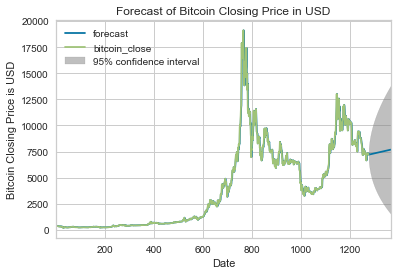

In [76]:
# Plot original, modeled, and forecasted prices
model_fit.plot_predict(start=1, end=len(final.bitcoin_close) + 90, dynamic=False, alpha=0.05)
plt.xlabel('Date')
plt.ylabel('Bitcoin Closing Price is USD')
plt.title('Forecast of Bitcoin Closing Price in USD')

plt.show()

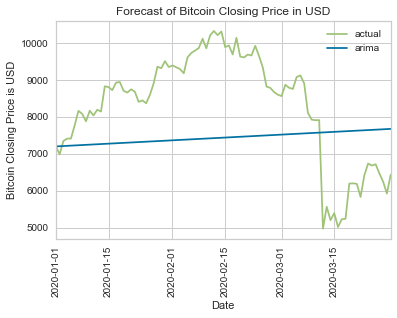

In [77]:
# Plot actual and forecasted prices
plt.plot(actual.date, actual.actual_close, c='g', label='actual')
plt.plot(actual.date, actual.arima_forecast, c='b', label='arima')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Bitcoin Closing Price is USD')
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.xlim(datetime.date(2020, 1, 1), datetime.date(2020, 3, 30))
plt.legend()

plt.show()

ARIMA out of sample forecasts tend to converge towards the sample mean for long forecasting periods, which may explain why the forecast is a straight line through the middle of the test set. In general, the ARIMA forecast above recapitulates the VAR forecast seen earlier, indicating that the underlying principles between VAR and ARIMA are similar (both autoregression models), especially since the ARIMA(0, 1, 0) model does not have a MA component. This result also indicates that the Dow time series was likely not playing a significant role in the VAR forecast, as previously hypothesized.

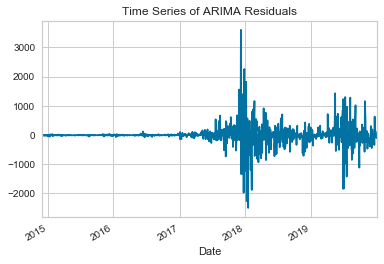

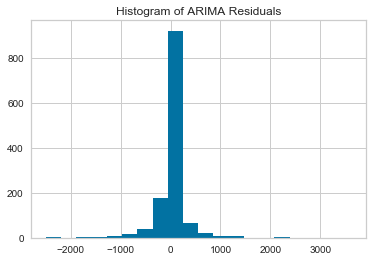

In [78]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of ARIMA Residuals')

residuals.hist(bins=20)
plt.title('Histogram of ARIMA Residuals')

plt.show()

See auto arima results above for discussion of these residual plots.

In [79]:
# Use RMSE and MAE to evaluate 7-day performance of ARIMA model
print('ARIMA(0, 1, 0) 7-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['arima_forecast'][0:7]) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['arima_forecast'][0:7]))

ARIMA(0, 1, 0) 7-Day Performance
RMSE: 432.02
MAE: 316.92


In [80]:
# Use RMSE and MAE to evaluate 90-day performance of ARIMA model
print('ARIMA(0, 1, 0) 90-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'], actual['arima_forecast']) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['arima_forecast']))

ARIMA(0, 1, 0) 90-Day Performance
RMSE: 1732.81
MAE: 1573.53


Based on test set performance, the ARIMA model performs slightly worse than the VAR model, with a 7-day RMSE and MAE of 432.02 and 316.92 and a 90-day RMSE and MAE of 1732.81 and 1573.53, respectively.

#### Summary

Much like the VAR model, the ARIMA model performed better than the FBP model in terms of test set performance, but still left a lot to be desired. Again, the residuals were not random and displayed a non-normal distribution, suggesting systematic errors in the model. The primary error seems to be the inability of these models to capture small-scale dynamic changes. Instead, they forecast in relatively straight lines.

### Exponential Smoothing Model

Next, I will use Holt Winter’s exponential smoothing model to predict future bitcoin closing prices. This technique assigns exponentially decreasing weights to past observations, thus giving more weight to more recent observations. This is in contrast to simple moving average techniques that apply equal weights to past observations. Typically, this model is used for seasonal data, so it may not perform super well on the bitcoin time series.

In [115]:
# Combine training and testing data into one data frame
# and reset index
training = final[['bitcoin_close']]
testing = actual[['actual_close']]
testing.rename(columns={'actual_close': 'bitcoin_close'}, inplace=True)
total = pd.concat([training, testing])
total.reset_index(inplace=True, drop=True)
total

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,bitcoin_close
0,379.244995
1,381.315002
2,375.010010
3,369.604004
4,376.854004
...,...
1363,6716.440430
1364,6469.798340
1365,6242.193848
1366,5922.042969


In [82]:
# Build exponential smoothing model
train, test = total.iloc[:1278, 0], total.iloc[1278:, 0]

model = ExponentialSmoothing(train,
                             trend='add',
                             damped=True,
                             seasonal='mul',
                             seasonal_periods=450)
model_fit = model.fit()
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 1278
Model:             ExponentialSmoothing   SSE                      115900417.652
Optimized:                         True   AIC                          15498.613
Trend:                         Additive   BIC                          17843.252
Seasonal:                Multiplicative   AICC                         16009.116
Seasonal Periods:                   450   Date:                 Sun, 19 Apr 2020
Box-Cox:                          False   Time:                         10:04:50
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8421053                alpha                 True
smoothing_slope       

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [83]:
# Use model to forecast bitcoin prices and store in
# actual data frame
actual['es_forecast'] = model_fit.predict(start=test.index[0], end=test.index[-1]).reset_index(drop=True)
actual

,actual_close,date,fbp_forecast,var_forecast,arima_forecast,es_forecast
0,7200.174316,2020-01-01,6623.369216,7301.501942,7198.935342,7298.958396
1,6985.470215,2020-01-02,6588.544523,7301.501942,7204.271563,7557.728657
2,7344.884277,2020-01-03,6553.886240,7307.116759,7209.607784,7725.968291
3,7410.656738,2020-01-04,6519.470163,7307.116759,7214.944005,7792.961865
4,7411.317383,2020-01-05,6485.377436,7307.116759,7220.280226,7658.097164
...,...,...,...,...,...,...
85,6716.440430,2020-03-26,4354.392369,7611.567377,7652.514121,4177.821371
86,6469.798340,2020-03-27,4376.606467,7616.908718,7657.850342,4257.441598
87,6242.193848,2020-03-28,4397.854482,7616.908718,7663.186563,4492.026879
88,5922.042969,2020-03-29,4417.721627,7616.908718,7668.522784,4431.989584


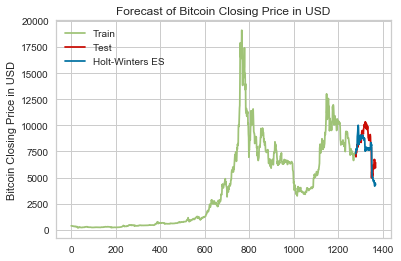

In [84]:
plt.plot(train.index, train, color='g', label='Train')
plt.plot(test.index, test, color='r', label='Test')
plt.plot(test.index, actual['es_forecast'], color='b', label='Holt-Winters ES')
plt.legend(loc='upper left')
plt.ylabel('Bitcoin Closing Price in USD')
plt.title('Forecast of Bitcoin Closing Price in USD')

plt.show()

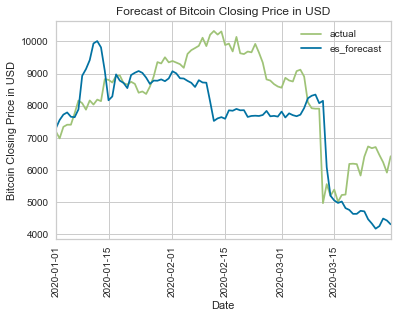

In [85]:
# Plot actual versus forecasted bitcoin prices
plt.plot(actual['date'], actual['actual_close'], c='g', label='actual')
plt.plot(actual['date'], actual['es_forecast'], c='b', label='es_forecast')
plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 3, 30)])
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.xlabel('Date')
plt.ylabel('Bitcoin Closing Price in USD')
plt.xticks(rotation=90)
plt.legend()
plt.show()

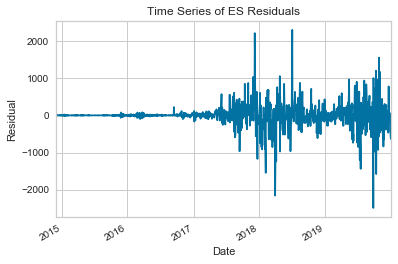

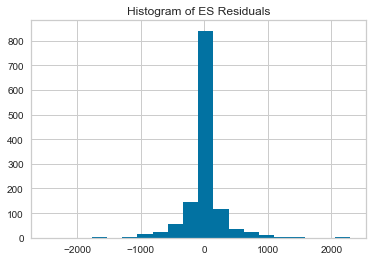

In [86]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Time Series of ES Residuals')

residuals.hist(bins=20)
plt.title('Histogram of ES Residuals')

plt.show()

In [87]:
jb_results = jarque_bera(residuals[0])

print('Test Statistic: ', jb_results[0])
print('P-value: ', jb_results[1])
print('Skew: ', jb_results[2])
print('Kurtosis: ', jb_results[3])

Test Statistic:  10908.063149820335
P-value:  0.0
Skew:  -0.2077515400547645
Kurtosis:  17.3064186128141


Unlike the VAR and ARIMA models tested previously, the exponential smoothing model was able to predict more accurately the small-scale dynamic changes in the bitcoin time series data. This largely came from tweaking the trend and seasonality parameters to minimize AIC, RMSE, and MAE. As we can see in the residual plots above, the residuals do appear to be slightly more random than seen in the previous models, but the distribution is still not normal due to high kurtosis (again, driven primarily by outliers).

In [88]:
# Use RMSE and MAE to evaluate 7-day performance of ES model
print('ES 7-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['es_forecast'][0:7]) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['es_forecast'][0:7]))

ES 7-Day Performance
RMSE: 334.04
MAE: 297.34


In [89]:
# Use RMSE and MAE to evaluate 90-day performance of ES model
print('ES 90-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'], actual['es_forecast']) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['es_forecast']))

ES 90-Day Performance
RMSE: 1343.87
MAE: 1079.00


In terms of AIC, RMSE, and MAE, the ES model performs similarly to the VAR model on a 7-day scale and significantly better than the FBP, VAR, and ARIMA models on a 90-day scale.

#### Summary

Although there is still room for improvement, primarily in the optimization of the trend and seasonality parameters, this ES model is the first model that is able to capture the small-scale dynamic changes seen in the bitcoin time series test data. This greatly increased the accuracy of the longer term predictions.

### Random Forest Regressor Plus ARIMA
Finally, I will test the ability of a random forest regressor to predict bitcoin prices based on external time series data and then feed this data into an ARIMA model. By using external features to predict actual bitcoin prices, we can potentially capture more noise within the time series data that will then help improve our forecasted values.

#### Select Features Using PCA

In [90]:
# Set feature and target variables
X = final[['cpi', 'dow_close', 'sp_close', 'usd_close', 'vix_close', 'interest', 'trend', 'unemploy']]
y = final['bitcoin_close']

# Standardize features
X = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=8)
principal_components = pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component:\n',
    pca.explained_variance_ratio_,
    '\n\nThe cumulative percentage of total variance in the dataset explained by',
    'the components:\n',
    pca.explained_variance_ratio_.cumsum()
)

The percentage of total variance in the dataset explained by each component:
 [6.22670908e-01 1.63739744e-01 1.34467179e-01 5.97260004e-02
 1.00395269e-02 7.23425867e-03 1.94397638e-03 1.78406774e-04] 

The cumulative percentage of total variance in the dataset explained by the components:
 [0.62267091 0.78641065 0.92087783 0.98060383 0.99064336 0.99787762
 0.99982159 1.        ]


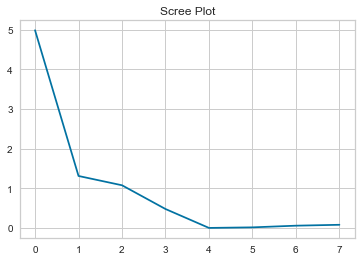

[4.98526810e+00 1.31094373e+00 1.07657983e+00 4.78182167e-01
 1.42837185e-03 1.55639895e-02 5.79193897e-02 8.03791094e-02]


In [91]:
# Print scree plot
Xt = X.T
Cx = np.cov(Xt)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.title('Scree Plot')
plt.show()

print(eig_val_cov)

Based on the cumulative percentage of total variance and the scree plot above, I will use the first 3 components as features in my random forest regressor model. These 3 components capture 92.1% of the variance in the bitcoin time series data set. Based on the univariate and bivariate analyses performed earlier that showed strong correlations between many of the external variables/features, it makes that all of the variables are not needed to capture a signficiant chunk of the variance in the data.

In [92]:
# Use 3 components as features in model
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X)
X_pca = pd.DataFrame(data=principal_components)
X_pca

,0,1,2
0,-2.850596,2.368484,0.559096
1,-2.798426,2.230374,0.197084
2,-2.789293,2.163604,0.081664
3,-2.787977,2.235316,0.086855
4,-2.783877,2.091227,-0.095715
...,...,...,...
1273,3.369957,-0.940109,-0.657875
1274,3.424228,-0.922134,-0.647823
1275,3.410917,-0.773433,-0.406973
1276,3.323305,-0.769852,-0.090930


#### Random Forest Regressor

In [93]:
# Create training and testing sets from X_pca and y
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=1234)

In [94]:
# Instantiate model
rfr = RandomForestRegressor()

# Fit model
rfr.fit(X_train, y_train)

# Use model to predict prices in X_test
y_pred = rfr.predict(X_test)

In [95]:
# # Evaluate performance of model on test set
print('MSE: %.2f'
      % mean_squared_error(y_test, y_pred))

print('RMSE: %.2f'
      % mean_squared_error(y_test, y_pred) ** 0.5)

print('R-Squared: %.2f'
      % r2_score(y_test, y_pred))

MSE: 564499.70
RMSE: 751.33
R-Squared: 0.96


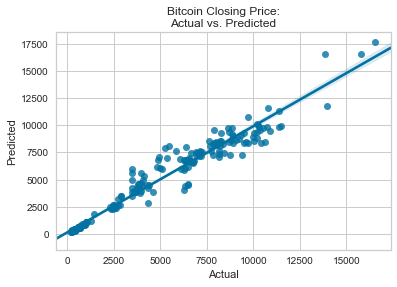

In [96]:
sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bitcoin Closing Price:\nActual vs. Predicted')

plt.show()

Here, we see pretty tight correlation between the actual and predicted values, with the most error occurring at the 12,500+ dollar range. These results suggest that an additional feature is likely needed to more accurately predict these outliers.

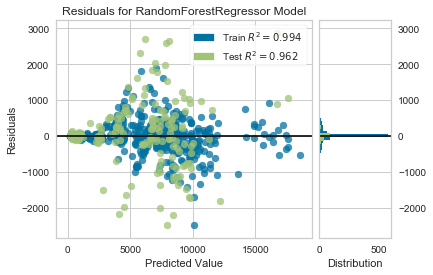

In [97]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(RandomForestRegressor(), X_train, y_train, X_test, y_test)

Using 3 principle components derived from the 8 variables discussed at the beginning of this notebook, the random forest regressor was able to accurately predict bitcoin prices in the training set and test set (R-squared of 0.99 for training set and 0.96 for the test set). The larger R-squared value for the training set suggests a bit of overfitting, which could potentially be fixed by using fewer features (maybe even 1 component as supported by the scree plot). Moreover, we see that the residuals for both the training and test set appear to be random and the histograms of the residuals are centered at 0 with relatively little skewness. Interestingly, the histogram for the training set still has high kurtosis while the histogram for the test set appears to be much closer to normal. This result suggests that the high kurtosis seen here, and likely the high kurtosis seen in all of my models, is driven by the small group of outliers in the 15000+ dollar range.

In [98]:
# Instantiate model
rfr = RandomForestRegressor()

# Fit model
rfr.fit(X_pca, y)

# Use model to predict bitcoin prices
y_pred = rfr.predict(X_pca)

# Store predicted values in a new data frame
rfr_final = final[['date']].copy()
rfr_final['rfr_bitcoin_close'] = y_pred

# Check data frame
rfr_final

,date,rfr_bitcoin_close
0,2014-12-01,372.908526
1,2014-12-02,378.341053
2,2014-12-03,373.129407
3,2014-12-04,371.525415
4,2014-12-05,370.347232
...,...,...
1273,2019-12-24,7316.592730
1274,2019-12-26,7304.767075
1275,2019-12-27,7200.228272
1276,2019-12-30,7327.173569


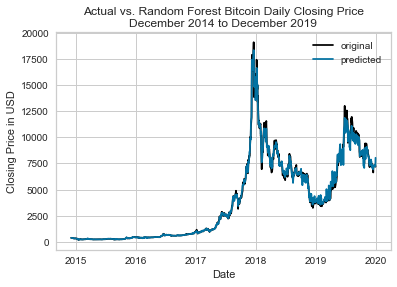

In [99]:
# Plot rfr predicted bitcoin time series
plt.plot(final['date'], final['bitcoin_close'], c='black', label='original')
plt.plot(final['date'], rfr_final['rfr_bitcoin_close'], c='b', label='predicted')

plt.title('Actual vs. Random Forest Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.legend()
plt.show()

As we can see, the random forest model closely predicts bitcoin prices in the training set; however, the ARIMA inputs from the random forest model will be slightly different than the actual bitcoin closing prices fed into the earlier ARIMA model.

#### ARIMA

In [100]:
# Use pd.auto_arima to optimize p and q based on AIC
stepwise_fit = pm.auto_arima(rfr_final.rfr_bitcoin_close,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18347.864, BIC=18368.473, Time=0.283 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=18350.552, BIC=18360.856, Time=0.062 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=18346.678, BIC=18362.135, Time=0.061 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18347.128, BIC=18362.584, Time=0.083 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=18349.006, BIC=18354.158, Time=0.021 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=18347.017, BIC=18367.626, Time=0.072 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18344.539, BIC=18370.301, Time=0.695 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18346.418, BIC=18377.332, Time=0.925 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=18344.682, BIC=18375.596, Time=1.031 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1278
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -9167.211
Date:                Sun, 19 Apr 2020   AIC                          18344.422
Time:                        10:05:01   BIC                          18370.184
Sample:                             0   HQIC                         18354.097
                               - 1278                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1246      2.177      0.517      0.605      -3.141       5.391
ar.L1          0.8144      0.071     11.395      0.000       0.674       0.954
ma.L1         -0.8840      0.072    -12.221      0.000      -1.026      -0.742
ma.L2          0.0966      0.016      5.960      0.000       0.065       0.128
sigma2      1.011e+05   1613.314     62.677      0.000     9.8e+04    1.04e+05
===================================================================================
Ljung-Box (Q):                      120.54   Jarque-Bera (JB):             10990.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             628.49   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Unlike for the original bitcoin time series, auto arima determined that a (1, 1, 2) model rather than a (0, 1, ) model would work best for the random forest predicted time series, as determined by a minimized AIC.

In [116]:
# Forecast using ARIMA(1, 1, 2) model
# Instantiate model
model = ARIMA(rfr_final.rfr_bitcoin_close, order=(1, 1, 2))

# Fit model
model_fit = model.fit()

# Use model to forecast and store in data frame
actual['rfr_arima_forecast'] = model_fit.forecast(steps=90)[0]
actual

,actual_close,date,fbp_forecast,var_forecast,arima_forecast,es_forecast,rfr_arima_forecast,average
0,7200.174316,2020-01-01,6623.369216,7301.501942,7198.935342,7298.958396,8001.221358,7285.214469
1,6985.470215,2020-01-02,6588.544523,7301.501942,7204.271563,7557.728657,8037.382270,7338.860997
2,7344.884277,2020-01-03,6553.886240,7307.116759,7209.607784,7725.968291,8067.951527,7371.066042
3,7410.656738,2020-01-04,6519.470163,7307.116759,7214.944005,7792.961865,8093.969109,7387.013489
4,7411.317383,2020-01-05,6485.377436,7307.116759,7220.280226,7658.097164,8116.281573,7356.271590
...,...,...,...,...,...,...,...,...
85,6716.440430,2020-03-26,4354.392369,7611.567377,7652.514121,4177.821371,8681.054045,6495.314503
86,6469.798340,2020-03-27,4376.606467,7616.908718,7657.850342,4257.441598,8687.150332,6517.996819
87,6242.193848,2020-03-28,4397.854482,7616.908718,7663.186563,4492.026879,8693.246619,6572.471957
88,5922.042969,2020-03-29,4417.721627,7616.908718,7668.522784,4431.989584,8699.342906,6565.709677


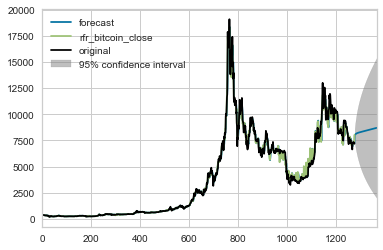

In [126]:
# Plot original, modeled, and forecasted prices
model_fit.plot_predict(start=1, end=len(rfr_final.rfr_bitcoin_close) + 90, dynamic=False, alpha=0.05)
final.bitcoin_close.plot(c='black', label='original')
plt.legend()
plt.show()

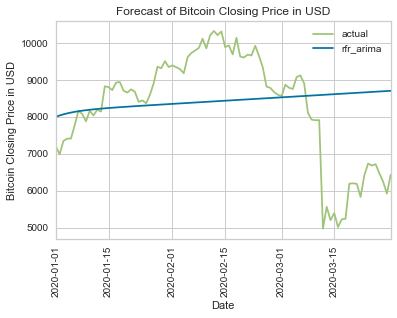

In [127]:
# Plot actual and forecasted prices
plt.plot(actual.date, actual.actual_close, c='g', label='actual')
plt.plot(actual.date, actual.rfr_arima_forecast, c='b', label='rfr_arima')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Bitcoin Closing Price in USD')
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.xlim(datetime.date(2020, 1, 1), datetime.date(2020, 3, 30))
plt.legend()

plt.show()

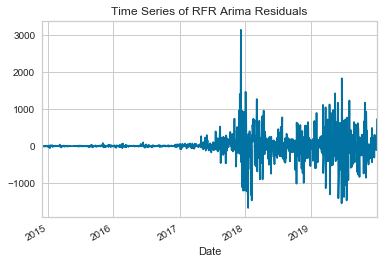

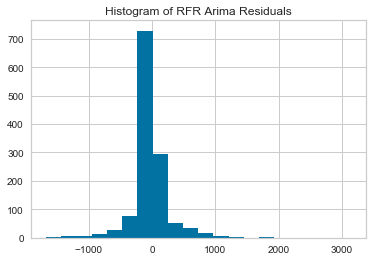

In [128]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of RFR Arima Residuals')

residuals.hist(bins=20)
plt.title('Histogram of RFR Arima Residuals')

plt.show()

In [129]:
# Evaluate 7-day performance of model on test set
print('Random Forest ARIMA(1, 1, 2) 7-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['rfr_arima_forecast'][0:7]) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['rfr_arima_forecast'][0:7]))

Random Forest ARIMA(1, 1, 2) 7-Day Performance
RMSE: 693.77
MAE: 620.28


In [130]:
# Evaluate 90-day performance of model on test set
print('Random Forest ARIMA(1, 1, 2) 90-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'], actual['rfr_arima_forecast']) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['rfr_arima_forecast']))

Random Forest ARIMA(1, 1, 2) 90-Day Performance
RMSE: 1522.50
MAE: 1179.43


As seen in the previous models, the residuals are still non-normal with a high kurtosis of 17.3. This model performed slighly worse than the VAR, ARIMA, and ES models described earlier, but better than the FBP model in terms of 7-day and 90-day RMSE and MAE.

#### Summary
Although this model performed slightly worse than the earlier ARIMA model, it offers a somewhat independent model based on slightly different input prices and ARIMA parameters that can then be used in combination with the previous models to create a better averaged model. Such averaged models may be slighlty less accurate than any one model on its own at a given time, but they tend to be more accurate overall (less bias, less likely to completely misforecast).

### Average Model

In [131]:
actual['average'] = actual[['fbp_forecast',
                            'var_forecast',
                            'arima_forecast',
                            'rfr_arima_forecast',
                            'es_forecast']].mean(axis=1)

actual.head()

,actual_close,date,fbp_forecast,var_forecast,arima_forecast,es_forecast,rfr_arima_forecast,average
0,7200.174316,2020-01-01,6623.369216,7301.501942,7198.935342,7298.958396,8001.221358,7284.797251
1,6985.470215,2020-01-02,6588.544523,7301.501942,7204.271563,7557.728657,8037.382270,7337.885791
2,7344.884277,2020-01-03,6553.886240,7307.116759,7209.607784,7725.968291,8067.951527,7372.906120
3,7410.656738,2020-01-04,6519.470163,7307.116759,7214.944005,7792.961865,8093.969109,7385.692380
4,7411.317383,2020-01-05,6485.377436,7307.116759,7220.280226,7658.097164,8116.281573,7357.430632


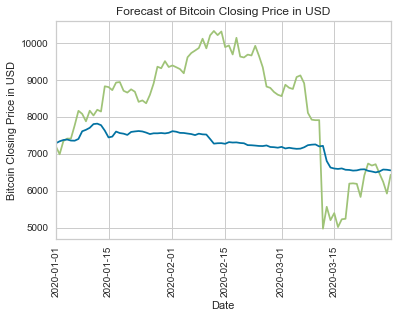

In [132]:
# Plot actual and forecasted prices
plt.plot(actual.date, actual.actual_close, c='g')
plt.plot(actual.date, actual.average, c='b')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Bitcoin Closing Price in USD')
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.xlim(datetime.date(2020, 1, 1), datetime.date(2020, 3, 30))

plt.show()

In [133]:
# Evaluate 7-day performance of model on test set
print('Average 7-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['average'][0:7]) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['average'][0:7]))

Average 7-Day Performance
RMSE: 356.37
MAE: 245.90


In [134]:
# Evaluate 90-day performance of model on test set
print('Average 90-Day Performance')
print('RMSE: %.2f'
      % mean_squared_error(actual['actual_close'], actual['average']) ** 0.5)

print('MAE: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['average']))

Average 90-Day Performance
RMSE: 1600.78
MAE: 1355.63


#### Summary
The averaged model is the strongest performer at the 7-day level in terms of MAE, and a close second to the ES model in terms of RMSE. However, it demonstrates a pretty average 90-day performance in terms of the individual models.

## Results Summary

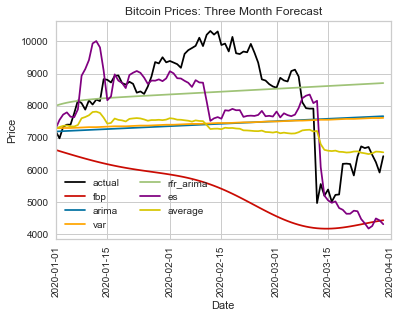

In [135]:
# Plot predicted values vs. actual values
plt.plot(actual['date'], actual['actual_close'], c='black', label='actual')
plt.plot(actual['date'], actual['fbp_forecast'], c='r', label='fbp')
plt.plot(actual['date'], actual['arima_forecast'], c='b', label='arima')
plt.plot(actual['date'], actual['var_forecast'], c='orange', label='var')
plt.plot(actual['date'], actual['rfr_arima_forecast'], c='g', label='rfr_arima')
plt.plot(actual['date'], actual['es_forecast'], c='purple', label='es')
plt.plot(actual['date'], actual['average'], c='y', label='average')

plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 4, 1)])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Prices: Three Month Forecast')
plt.legend(loc='lower left', ncol=2)

plt.show()

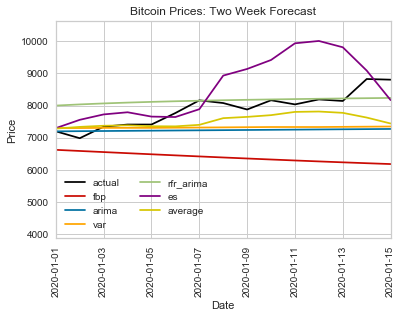

In [136]:
# Plot predicted values vs. actual values
plt.plot(actual['date'], actual['actual_close'], c='black', label='actual')
plt.plot(actual['date'], actual['fbp_forecast'], c='r', label='fbp')
plt.plot(actual['date'], actual['arima_forecast'], c='b', label='arima')
plt.plot(actual['date'], actual['var_forecast'], c='orange', label='var')
plt.plot(actual['date'], actual['rfr_arima_forecast'], c='g', label='rfr_arima')
plt.plot(actual['date'], actual['es_forecast'], c='purple', label='es')
plt.plot(actual['date'], actual['average'], c='y', label='average')

plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 1, 15)])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Prices: Two Week Forecast')
plt.legend(loc='lower left', ncol=2)

plt.show()

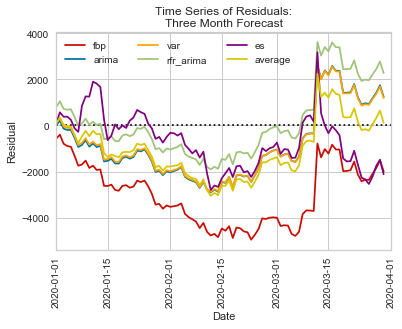

In [137]:
plt.plot(actual['date'], actual['fbp_forecast'] - actual['actual_close'], c='r', label='fbp')
plt.plot(actual['date'], actual['arima_forecast'] - actual['actual_close'], c='b', label='arima')
plt.plot(actual['date'], actual['var_forecast'] - actual['actual_close'], c='orange', label='var')
plt.plot(actual['date'], actual['rfr_arima_forecast'] - actual['actual_close'], c='g', label='rfr_arima')
plt.plot(actual['date'], actual['es_forecast'] - actual['actual_close'], c='purple', label='es')
plt.plot(actual['date'], actual['average'] - actual['actual_close'], c='y', label='average')

plt.hlines(0, xmin=[datetime.date(2020, 1, 1)], xmax=[datetime.date(2020, 4, 1)], colors='k', linestyles='dotted')
plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 4, 1)])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Time Series of Residuals:\nThree Month Forecast')
plt.legend(loc='upper left', ncol=3)

plt.show()

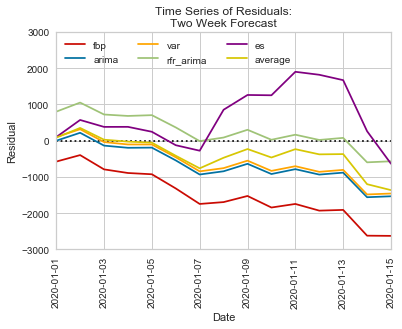

In [138]:
plt.plot(actual['date'], actual['fbp_forecast'] - actual['actual_close'], c='r', label='fbp')
plt.plot(actual['date'], actual['arima_forecast'] - actual['actual_close'], c='b', label='arima')
plt.plot(actual['date'], actual['var_forecast'] - actual['actual_close'], c='orange', label='var')
plt.plot(actual['date'], actual['rfr_arima_forecast'] - actual['actual_close'], c='g', label='rfr_arima')
plt.plot(actual['date'], actual['es_forecast'] - actual['actual_close'], c='purple', label='es')
plt.plot(actual['date'], actual['average'] - actual['actual_close'], c='y', label='average')

plt.hlines(0, xmin=[datetime.date(2020, 1, 1)], xmax=[datetime.date(2020, 1, 15)], colors='k', linestyles='dotted')
plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 1, 15)])
plt.ylim(-3000, 3000)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Time Series of Residuals:\nTwo Week Forecast')
plt.legend(loc='upper left', ncol=3)

plt.show()

In conclusion, we can see based on the plots above, that the ARIMA and VAR models are almost superimposable, with the VAR demonstrating a slight advantage in terms of RMSE and MAE. These two models essentially cut the bitcoin closing price time series right down the middle, which is also demonstrated by the 90-day residuals widely oscillating around 0. In contrast, the FBP model seems to be offset in such a way that it constantly under predicts the price of bitcoin. Although none of the models are incredibly accurate, especially over the 1-month time frame I was hoping to be able to forecast, it does appear that the averaged model could have some utility in forecasting bitcoin prices, especially 1 to 5 days into the future. Although not as beneficial as a longterm forecast, these short forecasts could still offer a finanical advantage by providing interested individuals with an idea of whether the bitcoin price will increase or decrease over the next week.

## Data Product Summary

Moving forward, I will use the averaged model to forecast bitcoin prices. I selected this model because it offers the advantages of the best models, including VAR, while also minimizing the inherent bias or errors of any one given model. This is depicted in the residual plot of the two-week forecast, as the average model appears to produce the smallest residuals over the course of the full two weeks. As mentioned earlier, any one given model may forecast bitcoin prices more accurately than the averaged model at any given time (such as the ARIMA model over the first 3 days and the random forest arima over the second week), but the accuracy of the averaged model over the entire forecasted period will likely be superior.

This model begins to solve an interesting problem that I deal with on a monthly basis, which is whether I should buy or sell bitcoin at any given time. I currently buy bitcoin on a calendar schedule, but I thought that if I could accurately forecast bitcoin prices a month at a time, I could try to buy bitcoin at the lowest point each month. I knew this was an ambitious proposal, as I do not have much crytocurrency domain knowledge, econonomic expertise, or time series expertise, but I felt like it was a good way to learn a bit about all three. Unfortunately, the models I tested underperformed and would not be great predictors of bitcoin prices over 1+ months. Thus, I have tweaked the purpose of my data product to predict bitcoin prices over the course of two weeks. Although not as financially advantageous, it could still provide bitcoin buyers and sellers a financial advantage by providing some insight into whether bitcoin prices are rising or falling. For example, rather than just blindly buying bitcoin or trying to predict whether prices will increase or decrease in the next day or two by looking at the time series on the crypto exchange, I could just run this notebook and provide a one week forecast of bitcoin prices. With this forecast in hand, I could then decide whether to buy, sell, or wait.

I am not very familiar with the production side of things, but I imagine a scenario where historical bitcoin and dow closing prices are downloaded daily from finances.yahoo.com or some equivalent source and fed into a cleaned up and more automated version of the average model shown here. My hope is that there would also be a research team working to uncover and test additional external time series in an effort to improve the forecasting accuracy of the model by capturing more variance. Two potential variables/features I thought about, but was unable to get my hands on for this project, are daily number of bitcoin available and daily number of transactions. These could serve as proxies for supply and demand, respectively. These variables would likely be stronger predictors of bitcoin prices than Dow prices. The user interface would be an app that provides the user with a week of forecasted bitcoin prices, including a 95% confidence interval.